In [55]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

torch.manual_seed(0)
device = torch.device("cuda")

## LOADING MNIST DATA

In [102]:
# Download and preprocess the MNIST dataset
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
train_dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_dataset = datasets.MNIST(root='./data', train=False, transform=transform, download=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

In [103]:
all_labels = []
train_features, train_labels = next(iter(train_dataloader))
all_labels.extend(train_labels.tolist())
unique_labels = set(all_labels)
print("All labels:", unique_labels)

All labels: {0, 1, 2, 4, 5, 6, 7, 8, 9}


Feature batch shape: torch.Size([32, 1, 28, 28])
Labels batch shape: torch.Size([32])


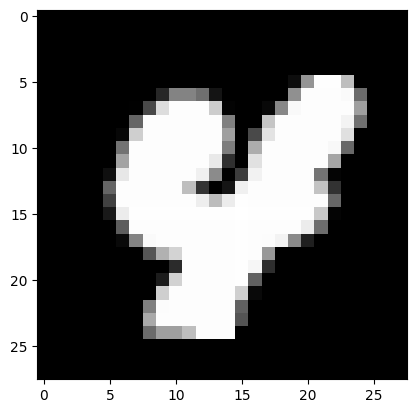

Label: 4


In [104]:
# Display image and label.
train_features, train_labels = next(iter(train_dataloader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")
img = train_features[0].squeeze()
label = train_labels[0]
plt.imshow(img, cmap="gray")
plt.show()
print(f"Label: {label}")

## Model Architecture 

# 1. Simple Neural Network

In [99]:
class SimpleNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = x.view(x.size(0), -1)  # Flatten the input
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x

# Hyperparameters
input_size = 28 * 28  # MNIST images are 28x28 pixels
hidden_size = 128
output_size = 10  # 10 classes for digits 0-9
learning_rate = 0.001
batch_size = 64
epochs = 10

# Initialize the model, loss function, and optimizer
model = SimpleNN(input_size, hidden_size, output_size)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Training loop
for epoch in range(epochs):
    model.train()
    total_loss = 0.0

    for images, labels in train_loader:
        outputs = model(images)
        loss = criterion(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    average_loss = total_loss / len(train_loader)
    print(f"Epoch [{epoch + 1}/{epochs}], Loss: {average_loss:.4f}")


### Saving Model

In [157]:
torch.save(model.state_dict(), './models/simple_nn.pth')

### Accuracy

In [160]:
model.load_state_dict(torch.load('./models/convNetTest_mnist.pth'))
def calculate_accuracy(model, data_loader):
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in data_loader:
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    accuracy = correct / total
    return accuracy

test_accuracy = calculate_accuracy(model, test_loader)
print(f"Test Accuracy: {test_accuracy:.4f}")

d:\Study\Projects\llm\venv\Lib\site-packages\torch\nn\functional.py:1345: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


Test Accuracy: 0.0989


# 2. Convolutional Neural Network

In [145]:
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 128, 3)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(128, 16, 5)
        self.fc1 = nn.Linear(16 * 4 * 4, 120)  # Adjusted input size based on conv2 output
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1)  # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# Create an instance of the ConvNet
convNet = ConvNet()

In [148]:
for epoch in range(10):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = convNet(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
            running_loss = 0.0

print('Finished Training')

Finished Training


In [150]:
# model.load_state_dict(torch.load('./models/cnn_mnist.pth'))
def calculate_accuracy(model, data_loader):
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in data_loader:
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = correct / total
    return accuracy

test_accuracy = calculate_accuracy(convNet, test_loader)
print(f"Test Accuracy: {test_accuracy:.4f}")

Test Accuracy: 0.0734


In [154]:
class ConvoNet(nn.Module):
    def __init__(self):
        super(ConvoNet, self).__init__()
        self.cn1 = nn.Conv2d(1, 16, 3, 1)
        self.cn2 = nn.Conv2d(16, 32, 3, 1)
        self.dp1 = nn.Dropout2d(0.10)
        self.dp2 = nn.Dropout2d(0.25)
        self.fc1 = nn.Linear(4608, 64) # 4608 is basically 12 X 12 X 32
        self.fc2 = nn.Linear(64, 10)
 
    def forward(self, x):
        x = self.cn1(x)
        x = F.relu(x)
        x = self.cn2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = self.dp1(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dp2(x)
        x = self.fc2(x)
        op = F.log_softmax(x, dim=1)
        return op

convNetTest=ConvoNet()
def train(model, device, train_dataloader, optim, epoch):
    model.train()
    for b_i, (X, y) in enumerate(train_dataloader):
        X, y = X.to(device), y.to(device)
        optim.zero_grad()
        pred_prob = model(X)
        loss = F.nll_loss(pred_prob, y) # nll is the negative likelihood loss
        loss.backward()
        optim.step()
        if b_i % 10 == 0:
            print('epoch: {} [{}/{} ({:.0f}%)]\t training loss: {:.6f}'.format(
                epoch, b_i * len(X), len(train_dataloader.dataset),
                100. * b_i / len(train_dataloader), loss.item()))
def test(model, device, test_dataloader):
    model.eval()
    loss = 0
    success = 0
    with torch.no_grad():
        for X, y in test_dataloader:
            X, y = X.to(device), y.to(device)
            pred_prob = model(X)
            loss += F.nll_loss(pred_prob, y, reduction='sum').item()  # loss summed across the batch
            pred = pred_prob.argmax(dim=1, keepdim=True)  # us argmax to get the most likely prediction
            success += pred.eq(y.view_as(pred)).sum().item()

    loss /= len(test_dataloader.dataset)

    print('\nTest dataset: Overall Loss: {:.4f}, Overall Accuracy: {}/{} ({:.0f}%)\n'.format(
        loss, success, len(test_dataloader.dataset),
        100. * success / len(test_dataloader.dataset)))
torch.manual_seed(0)
device = torch.device("cpu")
model = ConvoNet()
optimizer = optim.Adadelta(model.parameters(), lr=0.5)


for epoch in range(1, 3):
    train(model, device, train_dataloader, optimizer, epoch)
    test(model, device, test_dataloader)



epoch: 1 [0/60000 (0%)]	 training loss: 2.310609
epoch: 1 [320/60000 (1%)]	 training loss: 1.924133
epoch: 1 [640/60000 (1%)]	 training loss: 1.313336
epoch: 1 [960/60000 (2%)]	 training loss: 0.796470
epoch: 1 [1280/60000 (2%)]	 training loss: 0.819801
epoch: 1 [1600/60000 (3%)]	 training loss: 0.678430
epoch: 1 [1920/60000 (3%)]	 training loss: 0.477235
epoch: 1 [2240/60000 (4%)]	 training loss: 0.526729
epoch: 1 [2560/60000 (4%)]	 training loss: 0.469570
epoch: 1 [2880/60000 (5%)]	 training loss: 0.243354
epoch: 1 [3200/60000 (5%)]	 training loss: 0.535540
epoch: 1 [3520/60000 (6%)]	 training loss: 0.250727
epoch: 1 [3840/60000 (6%)]	 training loss: 0.449397
epoch: 1 [4160/60000 (7%)]	 training loss: 0.415974
epoch: 1 [4480/60000 (7%)]	 training loss: 0.327603
epoch: 1 [4800/60000 (8%)]	 training loss: 0.501861
epoch: 1 [5120/60000 (9%)]	 training loss: 0.146283
epoch: 1 [5440/60000 (9%)]	 training loss: 0.372229
epoch: 1 [5760/60000 (10%)]	 training loss: 0.093487
epoch: 1 [6080/60

In [162]:
torch.save(convNetTest.state_dict(), './models/convNet_mnist.pth')